In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df_train = pd.read_csv('../data/processed/train_clean.csv', sep=';')

print(len(df_train))

TARGET='churn'

79830


In [67]:
numerical_cols = df_train.select_dtypes(include=['number']).columns.tolist()
print(numerical_cols)

un = df_train['numbcars_isnull'].unique()
if len(un) == 2 and set(un) == {0.0, 1.0}:
    print("esta variable debería ser categorica")

['rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'change_mou', 'change_rev', 'drop_vce_Mean', 'drop_dat_Mean', 'blck_vce_Mean', 'blck_dat_Mean', 'unan_vce_Mean', 'unan_dat_Mean', 'plcd_vce_Mean', 'plcd_dat_Mean', 'recv_vce_Mean', 'recv_sms_Mean', 'comp_vce_Mean', 'comp_dat_Mean', 'custcare_Mean', 'ccrndmou_Mean', 'cc_mou_Mean', 'inonemin_Mean', 'threeway_Mean', 'mou_cvce_Mean', 'mou_cdat_Mean', 'mou_rvce_Mean', 'owylis_vce_Mean', 'mouowylisv_Mean', 'iwylis_vce_Mean', 'mouiwylisv_Mean', 'peak_vce_Mean', 'peak_dat_Mean', 'mou_peav_Mean', 'mou_pead_Mean', 'opk_vce_Mean', 'opk_dat_Mean', 'mou_opkv_Mean', 'mou_opkd_Mean', 'drop_blk_Mean', 'attempt_Mean', 'complete_Mean', 'callfwdv_Mean', 'callwait_Mean', 'months', 'uniqsubs', 'actvsubs', 'totcalls', 'totmou', 'totrev', 'adjrev', 'adjmou', 'adjqty', 'avgrev', 'avgmou', 'avgqty', 'avg3mou', 'avg3qty', 'avg3rev', 'avg6mou', 'avg6qty', 'avg6rev', 'hnd_price', 'phones', '

In [68]:
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)

TARGET = 'churn'

#After checking there are no repeated Customer_ID values, that is not a relevant value even it is a number
df_train = df_train.drop(['Customer_ID'], axis=1)

# Separamos los tipos de columnas para analizarlas de forma diferente
categorical_cols = df_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df_train.select_dtypes(include=['number']).columns.tolist()

# Nos aseguramos de que la variable objetivo no está en las listas de predictoras
if TARGET in numerical_cols:
    numerical_cols.remove(TARGET)
if TARGET in categorical_cols:
    categorical_cols.remove(TARGET)

print(f"Variable Objetivo: {TARGET}")
print(f"\nVariables Numéricas ({len(numerical_cols)}): {numerical_cols}")
print(f"\nVariables Categóricas ({len(categorical_cols)}): {categorical_cols}")

X_train = df_train.drop(['churn'], axis=1)
y_train = df_train['churn']


Variable Objetivo: churn

Variables Numéricas (86): ['rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'change_mou', 'change_rev', 'drop_vce_Mean', 'drop_dat_Mean', 'blck_vce_Mean', 'blck_dat_Mean', 'unan_vce_Mean', 'unan_dat_Mean', 'plcd_vce_Mean', 'plcd_dat_Mean', 'recv_vce_Mean', 'recv_sms_Mean', 'comp_vce_Mean', 'comp_dat_Mean', 'custcare_Mean', 'ccrndmou_Mean', 'cc_mou_Mean', 'inonemin_Mean', 'threeway_Mean', 'mou_cvce_Mean', 'mou_cdat_Mean', 'mou_rvce_Mean', 'owylis_vce_Mean', 'mouowylisv_Mean', 'iwylis_vce_Mean', 'mouiwylisv_Mean', 'peak_vce_Mean', 'peak_dat_Mean', 'mou_peav_Mean', 'mou_pead_Mean', 'opk_vce_Mean', 'opk_dat_Mean', 'mou_opkv_Mean', 'mou_opkd_Mean', 'drop_blk_Mean', 'attempt_Mean', 'complete_Mean', 'callfwdv_Mean', 'callwait_Mean', 'months', 'uniqsubs', 'actvsubs', 'totcalls', 'totmou', 'totrev', 'adjrev', 'adjmou', 'adjqty', 'avgrev', 'avgmou', 'avgqty', 'avg3mou', 'avg3qty', 'avg3rev', 'avg6

In [69]:
for col in numerical_cols:
    # Contamos el número de valores únicos no nulos
    unique_values = X_train[col].unique()
    
    # Comprobamos si tiene exactamente 2 valores únicos y si son 0 y 1
    if len(unique_values) == 2 and set(unique_values) == {0.0, 1.0}:
        # Si la condición se cumple, convertimos la columna a tipo 'category'
        X_train[col] = X_train[col].astype('category')
        print(f"Columna '{col}' convertida a tipo categórico.")
    #print(f"Numerical column {col} has {len(unique_values)} unique values:\n")

for col in categorical_cols:
    unique_values = X_train[col].unique()
    #Convert from object to category
    df_train[col] = X_train[col].astype('category')
    #print(f"Categorical {col} has {len(unique_values)} unique values\n")

# Separamos los tipos de columnas para analizarlas de forma diferente
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['number']).columns.tolist()

print(categorical_cols, numerical_cols)

Columna 'truck' convertida a tipo categórico.
Columna 'rv' convertida a tipo categórico.
Columna 'forgntvl' convertida a tipo categórico.
Columna 'infobase_isnull' convertida a tipo categórico.
Columna 'rev_Mean_isnull' convertida a tipo categórico.
Columna 'hnd_price_isnull' convertida a tipo categórico.
Columna 'change_rev_isnull' convertida a tipo categórico.
Columna 'avg6rev_isnull' convertida a tipo categórico.
Columna 'lor_isnull' convertida a tipo categórico.
Columna 'adults_isnull' convertida a tipo categórico.
Columna 'income_isnull' convertida a tipo categórico.
Columna 'numbcars_isnull' convertida a tipo categórico.
['new_cell', 'crclscod', 'asl_flag', 'prizm_social_one', 'area', 'dualband', 'refurb_new', 'hnd_webcap', 'truck', 'rv', 'ownrent', 'dwlltype', 'marital', 'infobase', 'HHstatin', 'dwllsize', 'forgntvl', 'ethnic', 'kid0_2', 'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17', 'creditcd', 'infobase_isnull', 'rev_Mean_isnull', 'hnd_price_isnull', 'change_rev_isnull', 'avg6re

## Variables numéricas

In [70]:


# 1. Calculamos la matriz de correlación solo de las variables predictoras
corr_matrix_features = X_train[numerical_cols].corr().abs()

# 2. Creamos una máscara para seleccionar el triángulo superior de la matriz
#    Esto evita que veamos pares duplicados (ej. var_A con var_B y var_B con var_A)
upper_triangle = corr_matrix_features.where(np.triu(np.ones(corr_matrix_features.shape), k=1).astype(bool))

# 3. Buscamos los pares de variables que superen el umbral de correlación
umbral = 0.80
highly_correlated_pairs = upper_triangle.stack().reset_index()
highly_correlated_pairs.columns = ['Variable 1', 'Variable 2', 'Correlación']
highly_correlated_pairs = highly_correlated_pairs[highly_correlated_pairs['Correlación'] > umbral]

print(f"Pares de variables con una correlación mayor a {umbral}:")
if highly_correlated_pairs.empty:
    print("No se encontraron pares altamente correlacionados.")
else:
    print(highly_correlated_pairs)

Pares de variables con una correlación mayor a 0.8:
     Variable 1     Variable 2  Correlación
61     rev_Mean        avg3rev     0.915591
64     rev_Mean        avg6rev     0.810197
88     mou_Mean  plcd_vce_Mean     0.820167
92     mou_Mean  comp_vce_Mean     0.828435
99     mou_Mean  mou_cvce_Mean     0.859103
...         ...            ...          ...
2624    avg3qty        avg6mou     0.821227
2625    avg3qty        avg6qty     0.936568
2637    avg3rev        avg6rev     0.871931
2646    avg6mou        avg6qty     0.880626
2680     phones         models     0.890725

[96 rows x 3 columns]



Generando clustermap final para 55 variables...


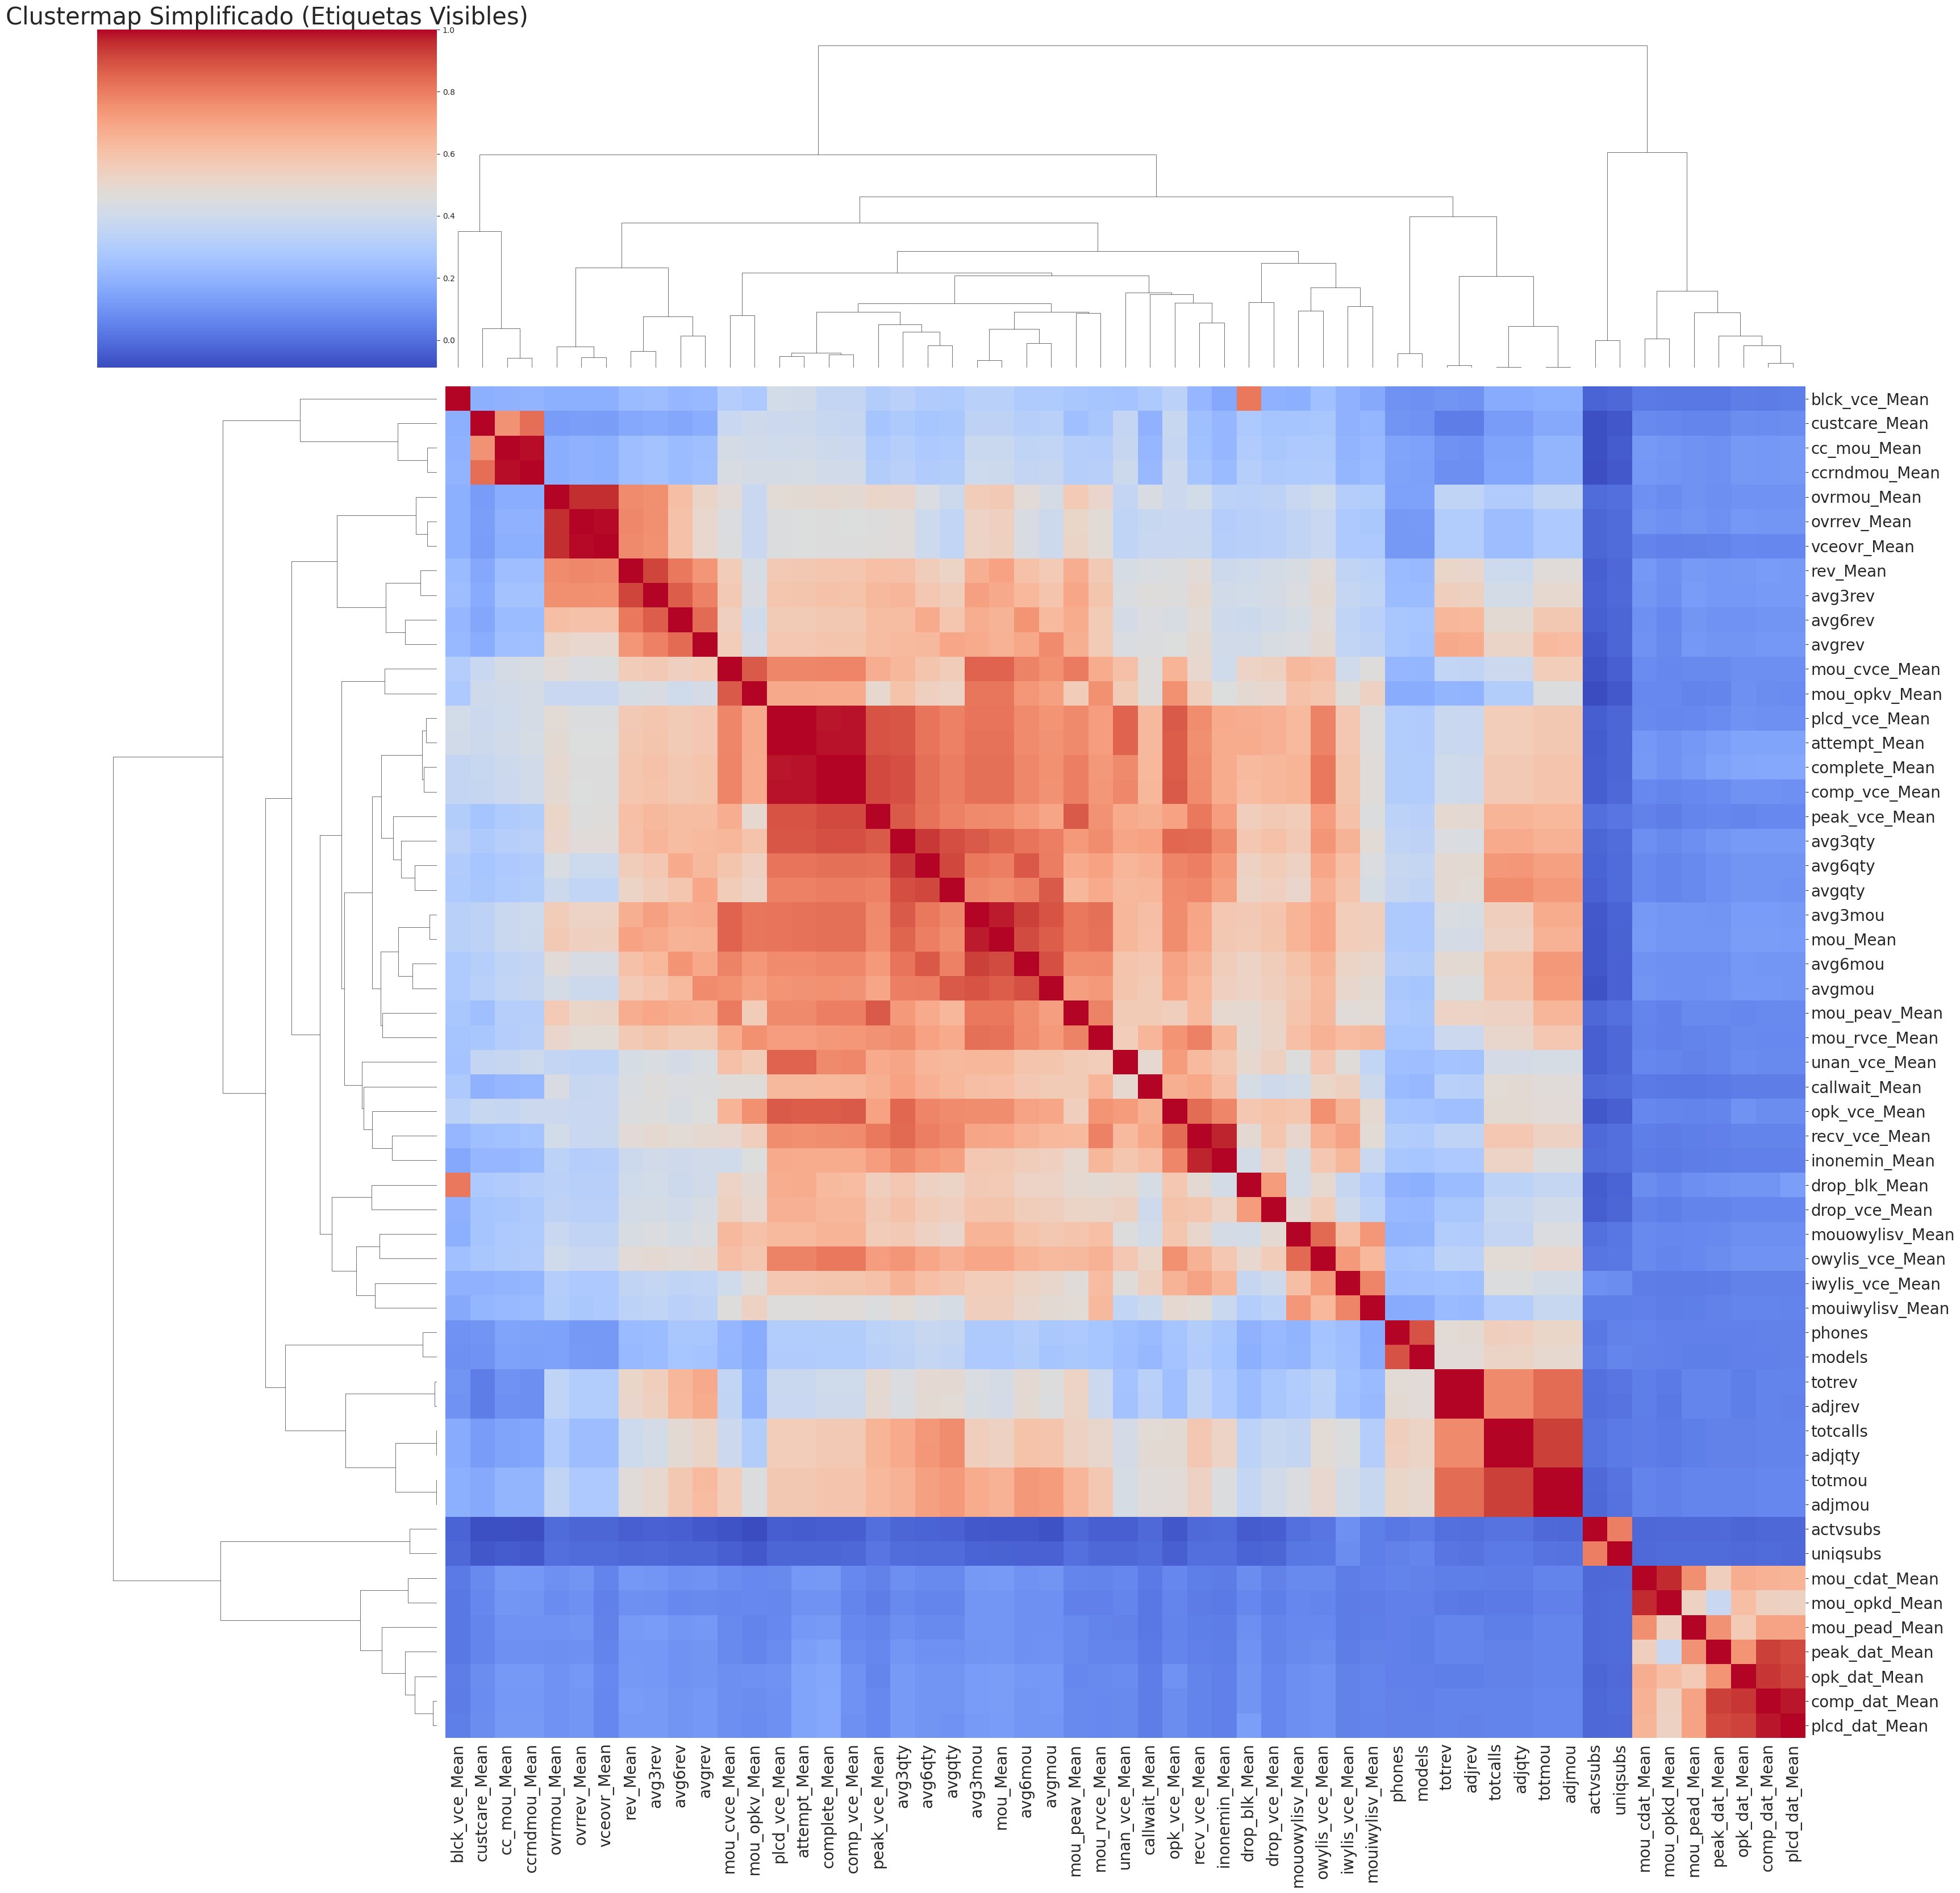

In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Definir umbral y filtrar variables con alta correlación
umbral = 0.7
corr_matrix_full = X_train[numerical_cols].corr().abs()
variables_a_mantener = set()
for col in corr_matrix_full.columns:
    correlaciones_altas = corr_matrix_full.loc[corr_matrix_full.index != col, col]
    if (correlaciones_altas >= umbral).any():
        variables_a_mantener.add(col)
lista_filtrada = list(variables_a_mantener)

if not lista_filtrada:
    print("\nNo se encontraron variables que superen el umbral para graficar.")
else:
    corr_matrix_filtrada = X_train[lista_filtrada].corr()

    num_variables = len(lista_filtrada)
    figsize_ajustado = (max(10, num_variables * 0.6), max(10, num_variables * 0.6))

    print(f"\nGenerando clustermap final para {num_variables} variables...")
    
    g = sns.clustermap(
        corr_matrix_filtrada,
        cmap='coolwarm',
        annot=False,         
        figsize=figsize_ajustado
    )
    
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90, fontsize=20)
    plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=20)

    plt.title('Clustermap Simplificado (Etiquetas Visibles)', fontsize=30)
    
    plt.tight_layout() 
    
    plt.show()



**Cluster 1 - Llamadas de voz:** desde `moulwysliv_Mean` hasta `plc_vce_Mean` vemos un cluster más o menos claro. Todas estas variables son referentes al uso que se da, ya sesa de intentos de llamada, media de minutos en un periodo de tiempo, media de llamadas, diferentes usos del servicio, etc. Por ejemplo, claramente `plcd_vce_Mean`, `attempt_Mean`, `complete_Mean` y `comp_vce_Mean` tiene sentido que tengan correlación porque implican las llamadas que se han intentado, las que se han intentado y han tenido lugar, el número de llamadas completadas, y el número de llamadas de voz completadas. tiene sentido, que cuantas más llamadas haya hecho un usuario, más se han logrado, más media hay, y más se han finalizado.

In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def analizar_correlacion_objetivo(X, y, top_n=10, figsize=(5, 5), title=None):
    # Asegurarse de que y tiene un nombre para la columna
    target_name = y.name if y.name else 'target'
    
    # 1. Combinar X e y en un solo DataFrame
    combined_df = pd.concat([X, y.rename(target_name)], axis=1)

    # 2. Calcular la matriz de correlación y seleccionar la columna del objetivo
    try:
        corr_with_target = combined_df.corr(numeric_only=True)[target_name]
    except KeyError:
        print(f"Error: La variable objetivo '{target_name}' no se encontró en la matriz de correlación.")
        return None

    # 3. Eliminar la correlación de la variable consigo misma y ordenar
    corr_with_target = corr_with_target.drop(target_name, errors='ignore').sort_values(ascending=False)
    
    # 4. Preparar los datos para la visualización (top N y bottom N)
    if len(corr_with_target) > top_n * 2:
        top_features = corr_with_target.head(top_n)
        bottom_features = corr_with_target.tail(top_n)
        features_to_plot = pd.concat([top_features, bottom_features])
    else:
        features_to_plot = corr_with_target

    # 5. Visualizar las correlaciones
    plt.figure(figsize=figsize)
    sns.barplot(x=features_to_plot.values, y=features_to_plot.index, palette="coolwarm", hue=features_to_plot.values)
    
    # Crear el título
    if title:
        plt.title(title, fontsize=16)
    else:
        plt.title(f'Top {top_n} Más y Menos Correlacionadas con "{target_name}"', fontsize=16)
        
    plt.xlabel('Coeficiente de Correlación de Pearson', fontsize=12)
    plt.ylabel('Características', fontsize=12)
    plt.tight_layout()
    plt.show()

    # 6. Imprimir las características más y menos correlacionadas
    #print(f"Top {top_n} características más correlacionadas (positivamente):")
    #print(corr_with_target.head(top_n))
    #print(f"\nTop {top_n} características menos correlacionadas (negativamente):")
    #print(corr_with_target.tail(top_n))
    
    # 7. Retornar la serie completa de correlaciones para uso posterior
    return corr_with_target

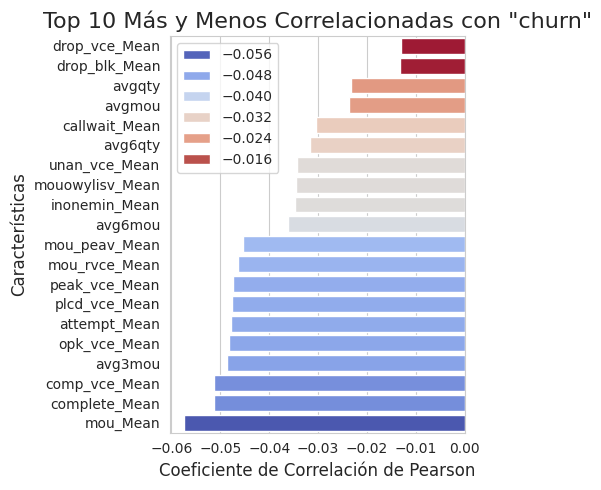

drop_vce_Mean     -0.012968
drop_blk_Mean     -0.013205
avgqty            -0.023182
avgmou            -0.023720
callwait_Mean     -0.030495
avg6qty           -0.031564
unan_vce_Mean     -0.034375
mouowylisv_Mean   -0.034558
inonemin_Mean     -0.034759
avg6mou           -0.036244
recv_vce_Mean     -0.041818
avg3qty           -0.043270
mou_peav_Mean     -0.045417
mou_rvce_Mean     -0.046410
peak_vce_Mean     -0.047459
plcd_vce_Mean     -0.047562
attempt_Mean      -0.047791
opk_vce_Mean      -0.048270
avg3mou           -0.048717
comp_vce_Mean     -0.051207
complete_Mean     -0.051370
mou_Mean          -0.057386
Name: churn, dtype: float64

In [73]:
values = g.ax_heatmap.get_yticklabels()

#Obtain the fields of the first cluster
cluster_1 = [tick.get_text() for tick in values[13:35]]

analizar_correlacion_objetivo(X_train[cluster_1], y_train)


Claramente, la que más afecta es `mou_Mean`, permitiéndonos prescindir de las demás variables del cluster.

In [74]:
var_1 = 'mou_Mean'

**Cluster 2 - Llamadas de datos:** desde `mou_cdat_Mean` hasta `plcd_dat_Mean`, relacionan los minutos de uso y el número de llamadas de **datos**, off-peak y peak. Tiene sentido que cuantas más llamadas de datos hagas, más minutos de uso tengas tanto en peak como en off-peak de llamadas de datos. Así como que cuantas más llamadas se hagan, más llamadas completas de datos habrá.


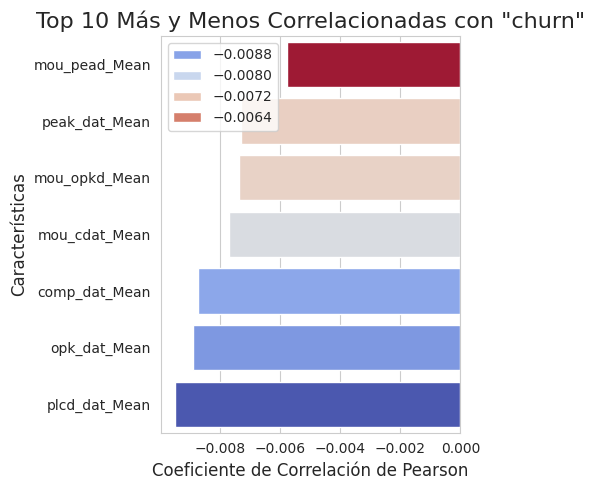

mou_pead_Mean   -0.005789
peak_dat_Mean   -0.007331
mou_opkd_Mean   -0.007372
mou_cdat_Mean   -0.007712
comp_dat_Mean   -0.008746
opk_dat_Mean    -0.008915
plcd_dat_Mean   -0.009514
Name: churn, dtype: float64

In [75]:
cluster_2 = [tick.get_text() for tick in values[len(values)-7:(len(values))]]

analizar_correlacion_objetivo(X_train[cluster_2], y_train)

Aquí vemos que la que más influye es `plcd_dat_Mean`, que son el número de llamadas de datos realizadas.

In [76]:
var_2 = 'plcd_dat_Mean'

**Cluster 3 - Uso extra:** desde `ovrmou_Mean` hasta `avg6rev`. Las variables referentes a `rev`, implican el beneficio de ese usuario, el dinero que haga pagado. El resto de variables, se refieren a servicios de `overage`, es decir, pagos extra. Tiene sentido que cuanto más uso hayan hecho de _overage_, más _revenue_ hayan proporcionado.


['ovrmou_Mean', 'ovrrev_Mean', 'vceovr_Mean', 'rev_Mean', 'avg3rev', 'avg6rev', 'avgrev']


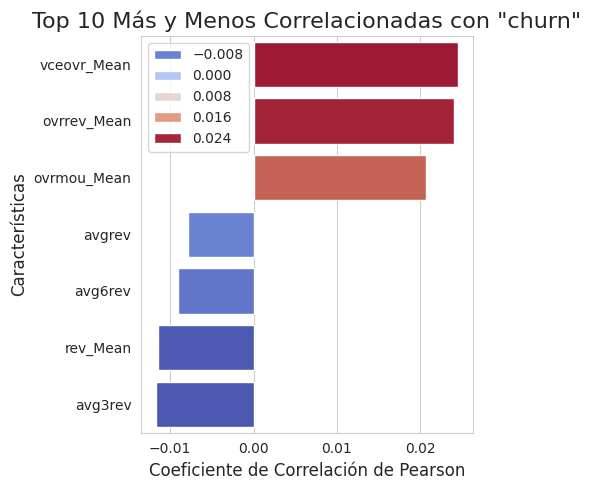

vceovr_Mean    0.024459
ovrrev_Mean    0.024058
ovrmou_Mean    0.020663
avgrev        -0.007911
avg6rev       -0.009011
rev_Mean      -0.011517
avg3rev       -0.011673
Name: churn, dtype: float64

In [77]:
cluster_3 = [tick.get_text() for tick in values[4:11]]
print(cluster_3)
analizar_correlacion_objetivo(X_train[cluster_3], y_train)

En este caso, lo que más influye son los usuarios que han proporcionado mayor beneficio en _voice overage_ de media

In [78]:
var_3 = 'vceovr_Mean'

**Cluster 4 - Uso y beneficio de toda la vida:** desde `totrev` a `adjmou` se refieren al uso y al pago referido al usuario durante toda su vida. Tiene sentido que cuantas más llamadas haya hecho el usuario, más beneficio de.


['totrev', 'adjrev', 'totcalls', 'adjqty', 'totmou', 'adjmou']


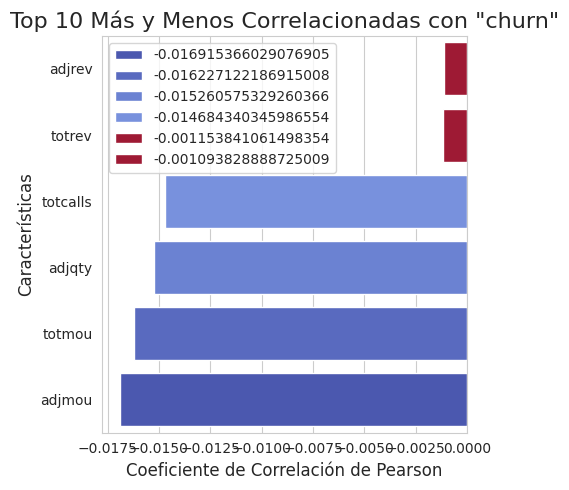

adjrev     -0.001094
totrev     -0.001154
totcalls   -0.014684
adjqty     -0.015261
totmou     -0.016227
adjmou     -0.016915
Name: churn, dtype: float64

In [79]:
cluster_4 = [tick.get_text() for tick in values[(len(values)-15):(len(values)-9)]]
print(cluster_4)
analizar_correlacion_objetivo(X_train[cluster_4], y_train)

En este caso, afecta más el número de minutos de uso a lo largo de toda la suscripción del usuario.

In [80]:
var_4 = 'adjmou'

**Cluster 5 - Customer care:** desde `custcare_Mean` hasta `ccrndmou_Mean`, todo referente al uso de atención al cliente. Cuantas más llamadas, más minutos se han usado.

['custcare_Mean', 'cc_mou_Mean', 'ccrndmou_Mean']


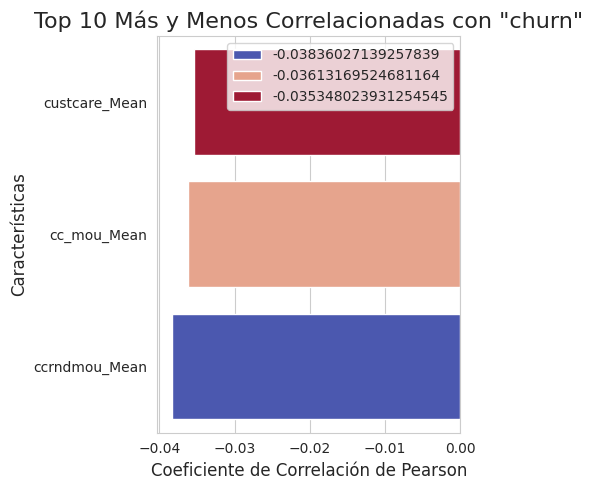

custcare_Mean   -0.035348
cc_mou_Mean     -0.036132
ccrndmou_Mean   -0.038360
Name: churn, dtype: float64

In [81]:
cluster_5 = [tick.get_text() for tick in values[1:4]]
print(cluster_5)
analizar_correlacion_objetivo(X_train[cluster_5], y_train)

In [82]:
var_5 = 'ccrndmou_Mean'

**Clusters 6 y 7 - Teléfonos y suscriptores:** apenas se les puede denominar clusteres, porque son grupos de dos variables. El primero, relacionando el número de teléfonos con el número de modelos de teléfono registrado, y el segundo relacionando el número de suscriptores únicos, con el número de suscriptores activos.

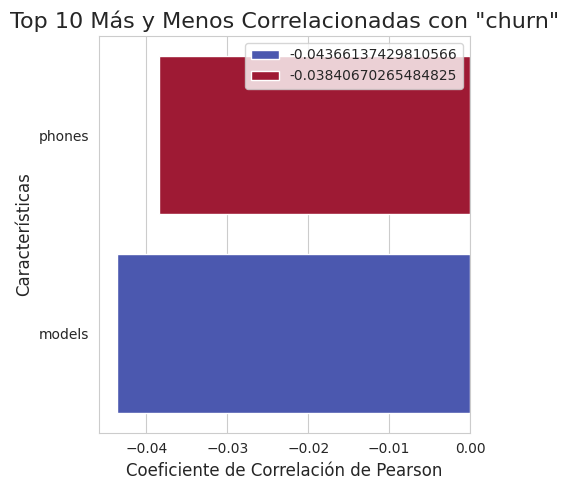

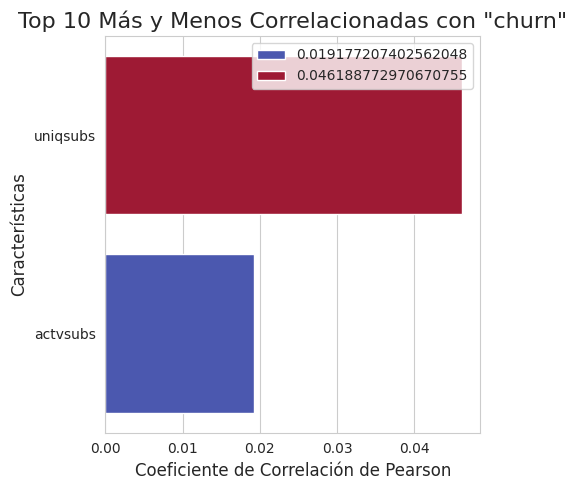

uniqsubs    0.046189
actvsubs    0.019177
Name: churn, dtype: float64

In [83]:
cluster_6 = ['models', 'phones']

analizar_correlacion_objetivo(X_train[cluster_6], y_train)

cluster_7 = ['uniqsubs', 'actvsubs']

analizar_correlacion_objetivo(X_train[cluster_7], y_train)

In [84]:
var_6 = 'models'
var_7 = 'uniqsubs'

numerical_filtered = [var_1, var_2, var_3, var_4, var_5, var_6, var_7]

## Variables categóricas

In [85]:
from scipy.stats import chi2_contingency
import pandas as pd

# Suponiendo que 'X_train' y 'y_train' están definidos
# y que 'categorical_cols' es una lista con los nombres de tus variables categóricas

# Identificar automáticamente las columnas categóricas si no tienes la lista
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Lista para guardar los resultados
chi2_results = []

for feature in categorical_cols:
    # Crear la tabla de contingencia
    contingency_table = pd.crosstab(X_train[feature], y_train)
    
    # Realizar el test de Chi-cuadrado
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    chi2_results.append({'Variable': feature, 'p-valor': p})

# Convertir los resultados a un DataFrame y ordenarlos por p-valor
results_df = pd.DataFrame(chi2_results).sort_values(by='p-valor', ascending=True)

print("Análisis de Relevancia (Chi-cuadrado) vs. Churn:")
print(results_df)

# Identificar variables potencialmente irrelevantes
irrelevantes = results_df[results_df['p-valor'] > 0.05]
print("\nVariables potencialmente irrelevantes (p-valor > 0.05):")
print(irrelevantes)

Análisis de Relevancia (Chi-cuadrado) vs. Churn:
             Variable        p-valor
7          hnd_webcap  1.387111e-145
2            asl_flag   8.416965e-83
1            crclscod   3.115777e-82
17             ethnic   7.337398e-58
5            dualband   7.665078e-54
27  change_rev_isnull   5.152051e-46
4                area   5.868406e-32
28     avg6rev_isnull   1.780861e-20
6          refurb_new   7.122739e-18
13           infobase   3.992315e-17
12            marital   2.783912e-15
24    infobase_isnull   6.523994e-14
30      adults_isnull   5.417143e-12
29         lor_isnull   7.801198e-12
11           dwlltype   3.965974e-11
25    rev_Mean_isnull   4.606931e-11
31      income_isnull   6.980290e-11
14           HHstatin   9.096220e-11
10            ownrent   2.788766e-09
26   hnd_price_isnull   6.380306e-09
3    prizm_social_one   2.425691e-07
23           creditcd   4.550669e-07
15           dwllsize   7.338899e-07
32    numbcars_isnull   2.834980e-04
18             kid0_2   2.

In [86]:
categories_to_discard = ['numbcars_isnull', 'kid0_2', 'kid16_17', 'forgntvl', 'kid3_5', 'kid11_15', 'kid6_10', 'truck', 'new_cell', 'rv']

# Hacemos una copia para no modificar la lista original
categorical_cols_filtered = categorical_cols.copy()

for col in categories_to_discard:
    # Es más eficiente iterar sobre la lista corta de descarte
    if col in categorical_cols_filtered:
        # Simplemente llamamos a .remove(), sin reasignar
        categorical_cols_filtered.remove(col)

print("\nLista de categorías filtrada:")
print(categorical_cols_filtered)


Lista de categorías filtrada:
['crclscod', 'asl_flag', 'prizm_social_one', 'area', 'dualband', 'refurb_new', 'hnd_webcap', 'ownrent', 'dwlltype', 'marital', 'infobase', 'HHstatin', 'dwllsize', 'ethnic', 'creditcd', 'infobase_isnull', 'rev_Mean_isnull', 'hnd_price_isnull', 'change_rev_isnull', 'avg6rev_isnull', 'lor_isnull', 'adults_isnull', 'income_isnull']


Corrigiendo tipos de datos a string para asegurar consistencia...
¡Tipos de datos corregidos!

Calculando la matriz de V de Cramér (esto puede tardar un momento)...
Matriz calculada.


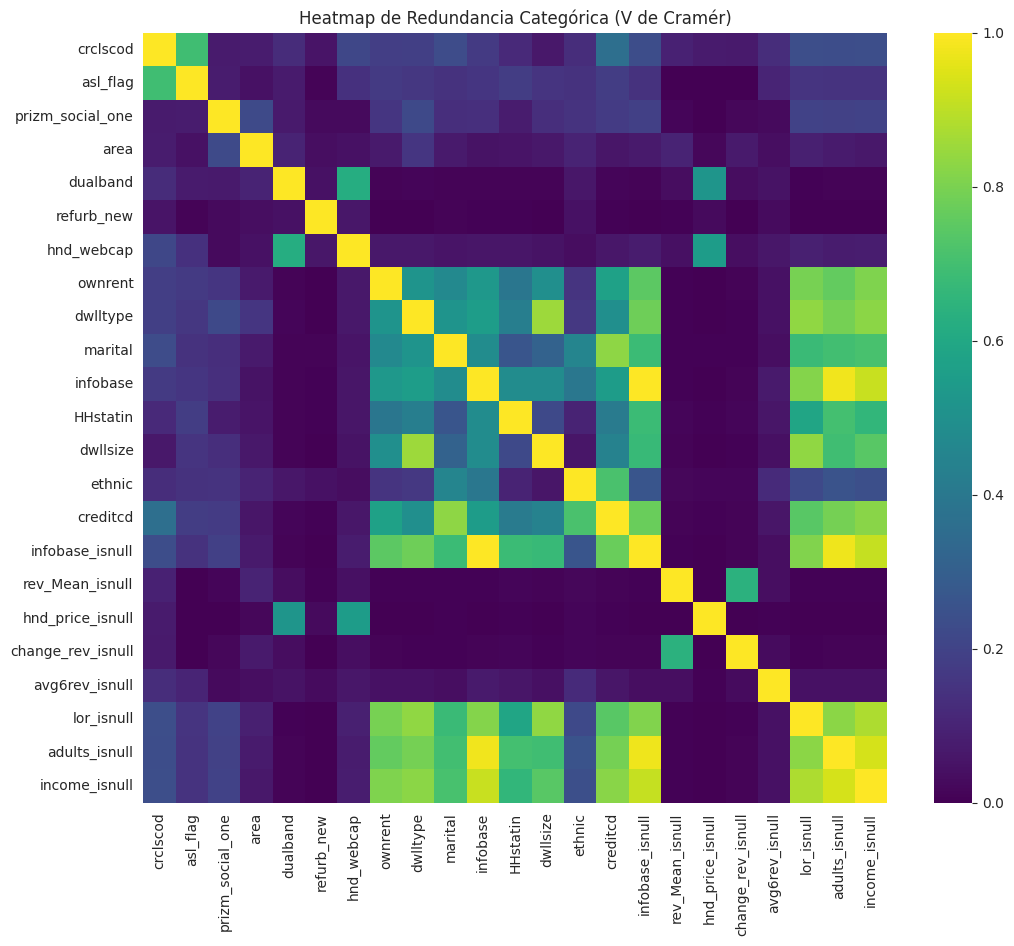

In [87]:
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convertimos todas las columnas categóricas a tipo string para evitar errores de tipo mixto.
print("Corrigiendo tipos de datos a string para asegurar consistencia...")
for col in categorical_cols:
    X_train[col] = X_train[col].astype(str)
print("¡Tipos de datos corregidos!")


def cramers_v(x, y):
    """ Calcula la V de Cramér entre dos series categóricas. """
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    if min((kcorr-1), (rcorr-1)) == 0:
        return 0
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Crear una matriz vacía para los resultados
cramers_matrix = pd.DataFrame(index=categorical_cols_filtered, columns=categorical_cols_filtered, dtype=float)

# Llenar la matriz con los valores de V de Cramér
print("\nCalculando la matriz de V de Cramér (esto puede tardar un momento)...")
for col1 in categorical_cols_filtered:
    for col2 in categorical_cols_filtered:
        cramers_matrix.loc[col1, col2] = cramers_v(X_train[col1], X_train[col2])
print("Matriz calculada.")

# Visualizar la matriz con un heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cramers_matrix, annot=False, cmap='viridis', fmt=".2f")
plt.title('Heatmap de Redundancia Categórica (V de Cramér)')
plt.show()

In [88]:
X_train['crclscod'].unique()

array(['BA', 'E4', 'A', 'EA', 'AA', 'CA', 'C', 'B', 'EM', 'DA', 'W', 'D4',
       'ZA', 'GA', 'B2', 'JF', 'A2', 'Z', 'G', 'E', 'M', 'I', 'C2', 'ZY',
       'U', 'CY', 'A3', 'U1', 'J', 'EC', 'O', 'V1', 'D5', 'D', 'Z5', 'C5',
       'Z4', 'K', 'Z1', 'L', 'CC', 'P1', 'GY', 'Y', 'IF', 'H', 'E2', 'EF',
       'D2', 'S', 'Z2', 'TP', 'V'], dtype=object)

Observando estas correlaciones con la V de Cramer, no vemos nada realmente nuevo. Observamos clusteres muy claros, pero lo que está sucediendo es que se está observando correlación entre las variables `_isnull` y las variables que representan. Por ejemplo, sabemos que cuando `infobase_isnull`, también son nulas las categorías `marital`, `ethnic`, etc. Por lo tanto, hay correlación con la variable 'UNKN'. Es decir: todas las variables `isnull` que tienen esta relaci´ón se podrían eliminar, porque son redundantes. En este caso, la primera que aparece como relevante, es `infobase_isnull`. Sin embargo, sabemos que `infobase` en el caso de ser nula, fue imputada con la categoría 'UNKN', con lo cual, `infobase_null` es un mapeo de esta variable, por lo tanto también es redundante y podríamos prescindir de ella.

Vemos es correlación entre `dualband`, `hnd_webcap` y `hnd_price_isnull`: tiene sentido, que sea dualband influye en la capacidad web del dispositivo, y eso hace que sea más caro. La primera que aparece como relevante es `hnd_webcap`, así que podemos prescindir tanto de `dualband` como de `hnd_price_isnull`.

También hay relación `rev_Mean_isnull` con `change_rev_isnull`, tiene sentido también porque igual `change_rev` se calcula cuando se conoce `rev_Mean`, y si es nula, no se podrá calcular. Se elimina `rev_Mean_isnull` porque su resultado p-valor es menor.

Vemos también que `asl_flag` tiene correlación con `crclscod`. Sin embargo no eliminamos ninguna porque `crclscod` tiene muchísimas más categorías y ambas son altamente predictivas con el churn.

Análisis de Relevancia (Chi-cuadrado) vs. Churn:

             Variable        p-valor

7          hnd_webcap  1.387111e-145

2          asl_flag   8.416965e-83

1          crclscod   3.115777e-82

17             ethnic   7.337398e-58

~~5          ~dualband   7.665078e-54~~

27  change_rev_isnull   5.152051e-46

4                area   5.868406e-32

28     avg6rev_isnull   1.780861e-20

6          refurb_new   7.122739e-18

13           infobase   3.992315e-17

12            marital   2.783912e-15

~~24    ~infobase_isnull   6.523994e-14~~

~~30      ~adults_isnull   5.417143e-12~~

~~29         ~lor_isnull   7.801198e-12~~

11           dwlltype   3.965974e-11

~~25    ~rev_Mean_isnull   4.606931e-11~~

~~31      income_isnull   6.980290e-11~~

14           HHstatin   9.096220e-11

10            ownrent   2.788766e-09

~~26   ~hnd_price_isnull   6.380306e-09~~

3    prizm_social_one   2.425691e-07

23           creditcd   4.550669e-07

15           dwllsize   7.338899e-07

In [89]:
categories_to_discard_2 = ['dualband', 'infobase_isnull', 'adults_isnull', 'lor_isnull', 'rev_Mean_isnull', 'hnd_price_isnull', 'income_isnull']

# Hacemos una copia para no modificar la lista original
categorical_cols_filtered_2 = categorical_cols_filtered.copy()

for col in categories_to_discard_2:
    # Es más eficiente iterar sobre la lista corta de descarte
    if col in categorical_cols_filtered_2:
        # Simplemente llamamos a .remove(), sin reasignar
        categorical_cols_filtered_2.remove(col)

print("\nLista de categorías filtrada:")
print(categorical_cols_filtered_2)

columns_to_use = numerical_filtered+categorical_cols_filtered_2

print(columns_to_use)


Lista de categorías filtrada:
['crclscod', 'asl_flag', 'prizm_social_one', 'area', 'refurb_new', 'hnd_webcap', 'ownrent', 'dwlltype', 'marital', 'infobase', 'HHstatin', 'dwllsize', 'ethnic', 'creditcd', 'change_rev_isnull', 'avg6rev_isnull']
['mou_Mean', 'plcd_dat_Mean', 'vceovr_Mean', 'adjmou', 'ccrndmou_Mean', 'models', 'uniqsubs', 'crclscod', 'asl_flag', 'prizm_social_one', 'area', 'refurb_new', 'hnd_webcap', 'ownrent', 'dwlltype', 'marital', 'infobase', 'HHstatin', 'dwllsize', 'ethnic', 'creditcd', 'change_rev_isnull', 'avg6rev_isnull']


In [ ]:
# --- Importaciones para la función ---
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def train_and_evaluate_model(model_name, hyperparameters, X_train, y_train, X_test, y_test):
    """
    Entrena y evalúa un modelo de clasificación.

    Args:
        model_name (str): El nombre del modelo ('RandomForest', 'XGBoost', 'LightGBM').
        hyperparameters (dict): Un diccionario con los hiperparámetros para el modelo.
        X_train, y_train, X_test, y_test: Los datos de entrenamiento y prueba.
    
    Returns:
        dict: Un diccionario con el modelo entrenado y sus métricas de rendimiento.
    """
    
    print("\n" + "="*60)
    print(f"--- ENTRENANDO Y EVALUANDO MODELO: {model_name} ---")
    print("="*60)
    
    # 1. SELECCIÓN DEL MODELO
    if model_name == 'RandomForest':
        model = RandomForestClassifier(**hyperparameters)
    elif model_name == 'XGBoost':
        model = XGBClassifier(**hyperparameters)
    elif model_name == 'LightGBM':
        model = LGBMClassifier(**hyperparameters)
    else:
        raise ValueError("Nombre de modelo no reconocido. Usa 'RandomForest', 'XGBoost', or 'LightGBM'.")

    # 2. ENTRENAMIENTO
    print(f"Entrenando {model_name}...")
    model.fit(X_train, y_train)
    print("¡Modelo entrenado!")

    # 3. PREDICCIÓN
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # 4. EVALUACIÓN
    auc = roc_auc_score(y_test, y_pred_proba)
    report = classification_report(y_test, y_pred, target_names=['No Churn', 'Churn'], output_dict=True)
    f1_churn = report['Churn']['f1-score']
    
    print(f"\n--- AUC en Test: {auc:.4f} ---")
    print("\n--- Informe de Clasificación en Test ---")
    # Imprimimos el reporte como texto para visualización
    print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))
    
    # 5. MATRIZ DE CONFUSIÓN
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn', 'Churn'])
    disp.plot(cmap='cividis')
    plt.title(f"Matriz de Confusión - {model_name}")
    plt.show()
    
    # 6. DEVOLVER RESULTADOS
    results = {
        'model_name': model_name,
        'model_object': model,
        'AUC Test': auc,
        'F1-Score Churn': f1_churn
    }
    
    return results

In [ ]:
# --- 1. PREPARACIÓN DE PARÁMETROS ---

# Parámetros para manejar clases desbalanceadas
try:
    scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
except IndexError:
    scale_pos_weight = 1

# Diccionarios de hiperparámetros para cada modelo
# Por ahora los dejamos con los básicos, pero aquí puedes experimentar
rf_params = {
    'n_estimators': 100,
    'random_state': 42,
    'n_jobs': -1,
    'class_weight': 'balanced'
}

xgb_params = {
    'n_estimators': 100,
    'random_state': 42,
    'n_jobs': -1,
    'scale_pos_weight': scale_pos_weight,
    'eval_metric': 'logloss'
}

lgbm_params = {
    'n_estimators': 100,
    'random_state': 42,
    'n_jobs': -1,
    'class_weight': 'balanced'
}

# --- 2. EJECUCIÓN DEL TORNEO ---

# Lista para guardar los resultados de cada modelo
all_results = []

# Entrenamos y evaluamos cada modelo con la misma función
# Asumo que ya tienes X_train, y_train, X_test_final y y_test listos
rf_results = train_and_evaluate_model('RandomForest', rf_params, X_train[columns_to_use], y_train, X_test[columns_to_use], y_test)
all_results.append(rf_results)

xgb_results = train_and_evaluate_model('XGBoost', xgb_params, X_train_final, y_train, X_test_final, y_test)
all_results.append(xgb_results)

lgbm_results = train_and_evaluate_model('LightGBM', lgbm_params, X_train_final, y_train, X_test_final, y_test)
all_results.append(lgbm_results)

In [ ]:
import pandas as pd
from typing import List

def group_rare_categories(df: pd.DataFrame, column: str, threshold: float = 0.05) -> pd.DataFrame:
    """
    Groups categories in a column with a frequency below the threshold
    into a new category called 'Others'.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        column (str): The name of the categorical column to process.
        threshold (float): The frequency threshold. Categories with a 
                           relative frequency below this value will be grouped.
                           The default is 0.05 (5%).

    Returns:
        pd.DataFrame: The DataFrame with the modified column.
    """
    # 1. Validate if the column exists in the DataFrame
    if column not in df.columns:
        print(f"Error: The column '{column}' was not found in the DataFrame.")
        return df

    # 2. Calculate the relative frequency of each category
    frequencies = df[column].value_counts(normalize=True)

    # 3. Identify the rare categories
    rare_categories = frequencies[frequencies < threshold].index.tolist()

    # 4. Check if there are categories to group
    if not rare_categories:
        print(f"No rare categories found to group in '{column}' with the threshold of {threshold}.")
        return df

    # 5. Group the rare categories
    df[column] = df[column].apply(lambda x: 'Others' if x in rare_categories else x)
    
    print(f"In column '{column}', {len(rare_categories)} rare categories were grouped into 'Others'.")
    print(f"The new cardinality is: {df[column].nunique()}")

    return df


In column 'crclscod', 50 rare categories were grouped into 'Others'.
The new cardinality is: 4
In column 'phones', 21 rare categories were grouped into 'Others'.
The new cardinality is: 3
In column 'models', 12 rare categories were grouped into 'Others'.
The new cardinality is: 3
In column 'lor', 14 rare categories were grouped into 'Others'.
The new cardinality is: 3
In column 'dwllsize', 14 rare categories were grouped into 'Others'.
The new cardinality is: 3
In column 'HHstatin', 4 rare categories were grouped into 'Others'.
The new cardinality is: 4
In column 'ethnic', 14 rare categories were grouped into 'Others'.
The new cardinality is: 5


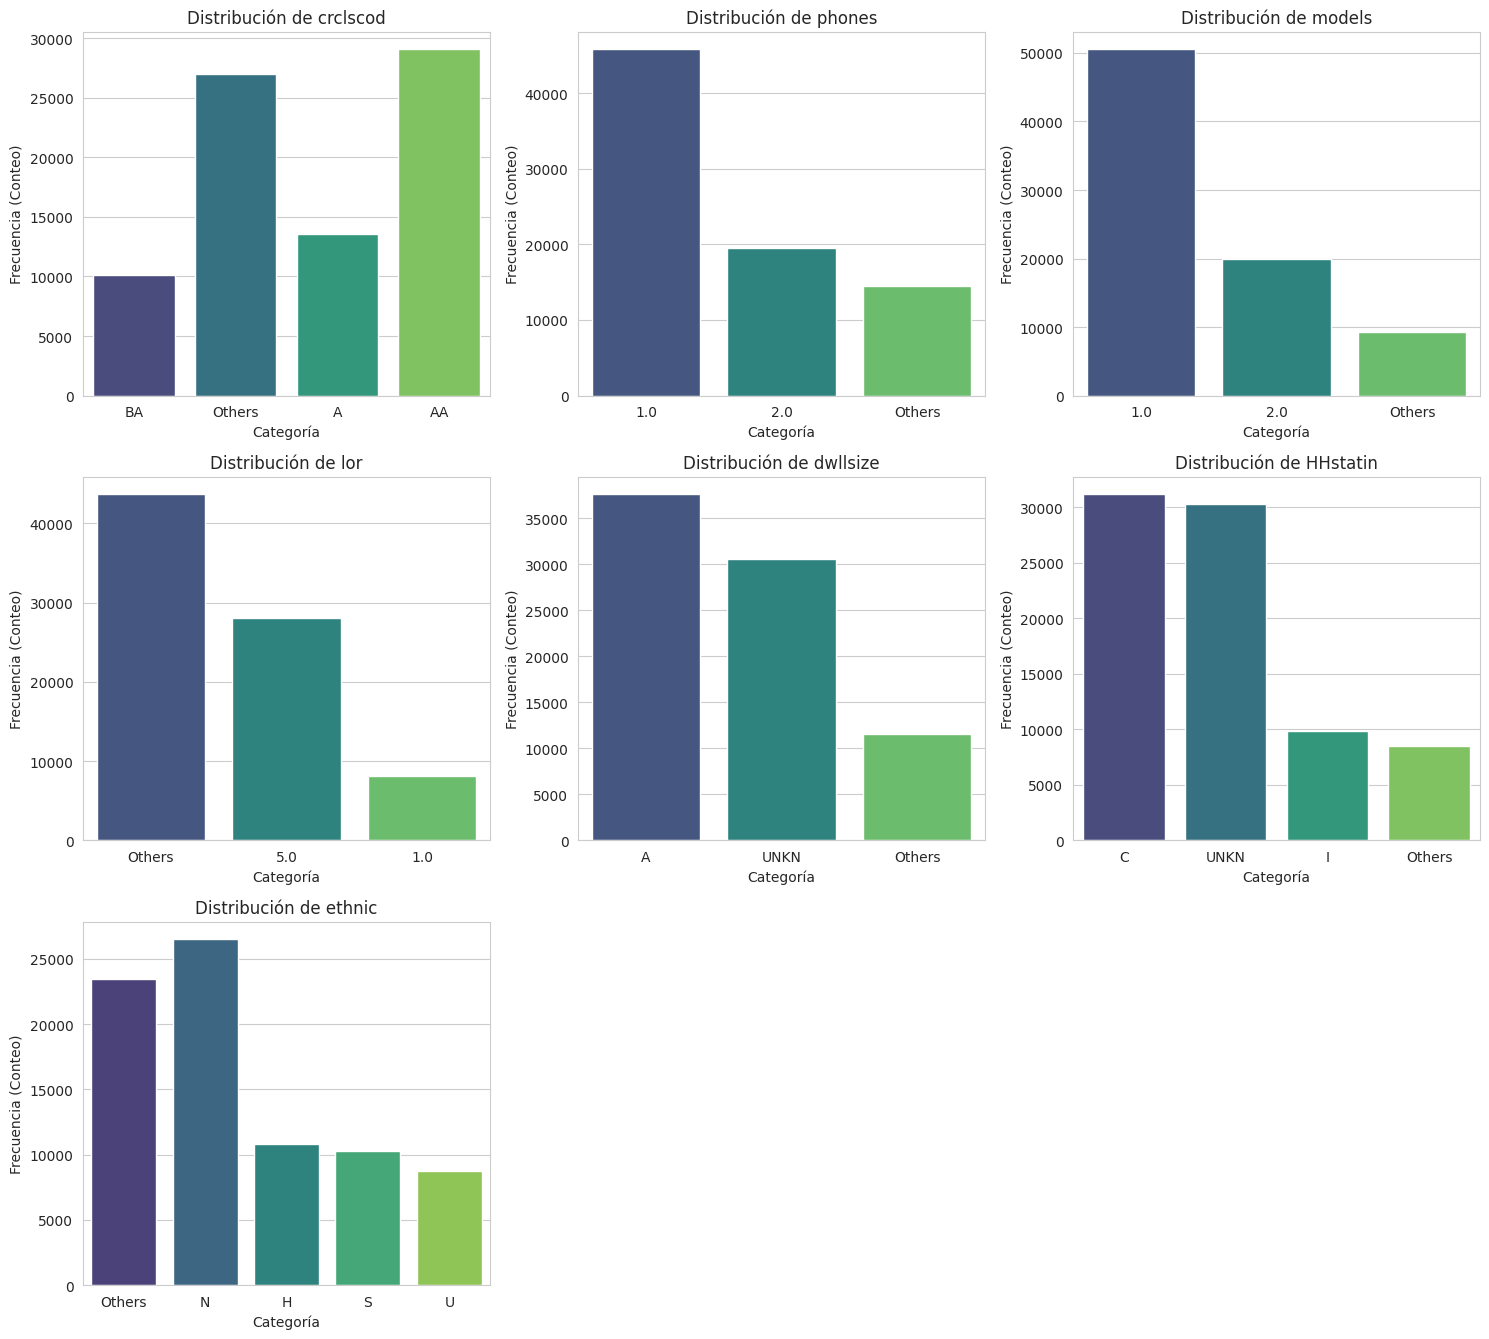

In [ ]:
# Apply the function to each column
cols_rare = ['crclscod', 'phones', 'models', 'lor', 'dwllsize', 'HHstatin', 'ethnic']

for col in cols_rare:
    group_rare_categories(df_train, col, threshold=0.1)

#graficar_distribuciones_categoricas(df_train, cols_rare)



In [ ]:
# La herramienta 'create_ratio' sigue siendo necesaria
def create_ratio(df, numerator_col, denominator_col, new_col_name, handle_inf_with=0):
    """Crea una nueva feature dividiendo dos columnas existentes de forma segura."""
    df_out = df.copy()
    epsilon = 1e-6
    new_col = df_out[numerator_col] / (df_out[denominator_col] + epsilon)
    new_col = new_col.replace([np.inf, -np.inf], np.nan).fillna(handle_inf_with)
    df_out[new_col_name] = new_col
    return df_out


def engineer_features(df):
    """
    Aplica la secuencia completa de FEATURE ENGINEERING a un DataFrame ya preprocesado.
    """
    print(f"Iniciando feature engineering (tamaño inicial: {df.shape})...")
    df_engineered = df.copy()
    
    # --- Herramienta 1: Ratios ---
    # Nota: Los ratios se deben crear ANTES del One-Hot Encoding, así que ajustamos el flujo.
    # Esta función ahora debería recibir el dataframe ANTES de get_dummies.
    # (Vamos a ajustar el flujo principal abajo para reflejar esto)
    df_engineered = create_ratio(df_engineered, 'rev_Mean', 'months', 'rev_per_month')
    df_engineered = create_ratio(df_engineered, 'mou_Mean', 'months', 'mou_per_month')
    df_engineered = create_ratio(df_engineered, 'change_mou', 'mou_Mean', 'change_mou_relative')
    
    # --- Herramienta 2: Binning ---
    bins = [-1, 90, 365, 730, df_engineered['eqpdays'].max()]
    labels = ['Equipo_Nuevo', 'Equipo_Seminuevo', 'Equipo_Antiguo', 'Equipo_Muy_Antiguo']
    df_engineered['eqpdays_binned'] = pd.cut(df_engineered['eqpdays'], bins=bins, labels=labels)

    print(f"Feature engineering completado. Nuevo tamaño: {df_engineered.shape}")
    return df_engineered

In [ ]:
def preprocess_data(df, imputation_values=None, train_cols_for_alignment=None):
    """
    Aplica la secuencia completa de PREPROCESAMIENTO a un DataFrame.
    (Limpieza, conversión de tipos, imputación y One-Hot Encoding).
    """
    print(f"Iniciando preprocesamiento (tamaño inicial: {df.shape})...")
    df_processed = df.copy()

    # --- 1. Limpieza Inicial ---
    if 'Customer_ID' in df_processed.columns:
        df_processed = df_processed.drop(columns=['Customer_ID'])
    
    # --- ¡NUEVO PASO! Gestionar valores infinitos ---
    # Reemplazamos cualquier 'inf' o '-inf' por NaN para que se puedan imputar después.
    df_processed.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # --- 2. Definición y Conversión de Tipos de Columnas ---
    numerical_cols = df_processed.select_dtypes(include=np.number).columns.drop(TARGET, errors='ignore').tolist()
    categorical_cols = df_processed.select_dtypes(include=['object', 'category']).columns.tolist()
    
    binary_cols = [
        col for col in numerical_cols 
        if df_processed[col].nunique(dropna=True) == 2 and set(df_processed[col].dropna().unique()) <= {0, 1, 0.0, 1.0}
    ]
    for col in binary_cols:
        df_processed[col] = df_processed[col].astype(int).astype('category')
        if col in numerical_cols:
            numerical_cols.remove(col)
        if col not in categorical_cols:
            categorical_cols.append(col)
            
    # --- 3. Imputación de Nulos ---
    if imputation_values:
        print("Aplicando imputación con valores del set de entrenamiento...")
        df_processed.fillna(value=imputation_values, inplace=True)

    # --- 4. One-Hot Encoding ---
    df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)
    
    # --- 5. Alineación de Columnas (para el test set) ---
    if train_cols_for_alignment is not None:
        print("Alineando columnas con el set de entrenamiento...")
        df_processed = df_processed.reindex(columns=train_cols_for_alignment, fill_value=0)
    
    print(f"Preprocesamiento completado. Nuevo tamaño: {df_processed.shape}")
    return df_processed

### Reducción de dimensionalidad

Entre PCA y Random Forest, por interpretabilidad, se escoge Random Forest, ya que PCA proyecta en dimensiones que complican la interpretación de las variables elegidas. Dado que se busca adoptar mejores alternativas de negocio y disminuir el churn, se escoge esta opción.

In [ ]:
X_train = df_train.drop(columns=[TARGET])
y_train = df_train[TARGET]

X_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)

print("DataFrame original:", X_train.shape)
print("DataFrame codificado:", X_encoded.shape)

DataFrame original: (79830, 107)
DataFrame codificado: (79830, 190)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_encoded, y_train)

feature_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("--- Top 20 Variables Más Importantes ---")
print(feature_importance.head(40))

--- Top 20 Variables Más Importantes ---
            feature  importance
65          eqpdays    0.031226
9        change_mou    0.024119
48           months    0.023173
52           adjrev    0.019895
51           totrev    0.019833
1          mou_Mean    0.019785
57           avgqty    0.019633
10       change_rev    0.019284
55           avgrev    0.019127
56           avgmou    0.018888
0          rev_Mean    0.018489
49         totcalls    0.018364
54           adjqty    0.018212
58          avg3mou    0.018197
50           totmou    0.018140
53           adjmou    0.018001
61          avg6mou    0.016914
37    mou_peav_Mean    0.016906
28    mou_cvce_Mean    0.016790
41    mou_opkv_Mean    0.016683
59          avg3qty    0.016622
62          avg6qty    0.016255
32  mouowylisv_Mean    0.016209
2       totmrc_Mean    0.016024
30    mou_rvce_Mean    0.015706
35    peak_vce_Mean    0.015381
63          avg6rev    0.015200
39     opk_vce_Mean    0.015103
15    unan_vce_Mean    0.014940

### Elbow Method para elegir el número de variables

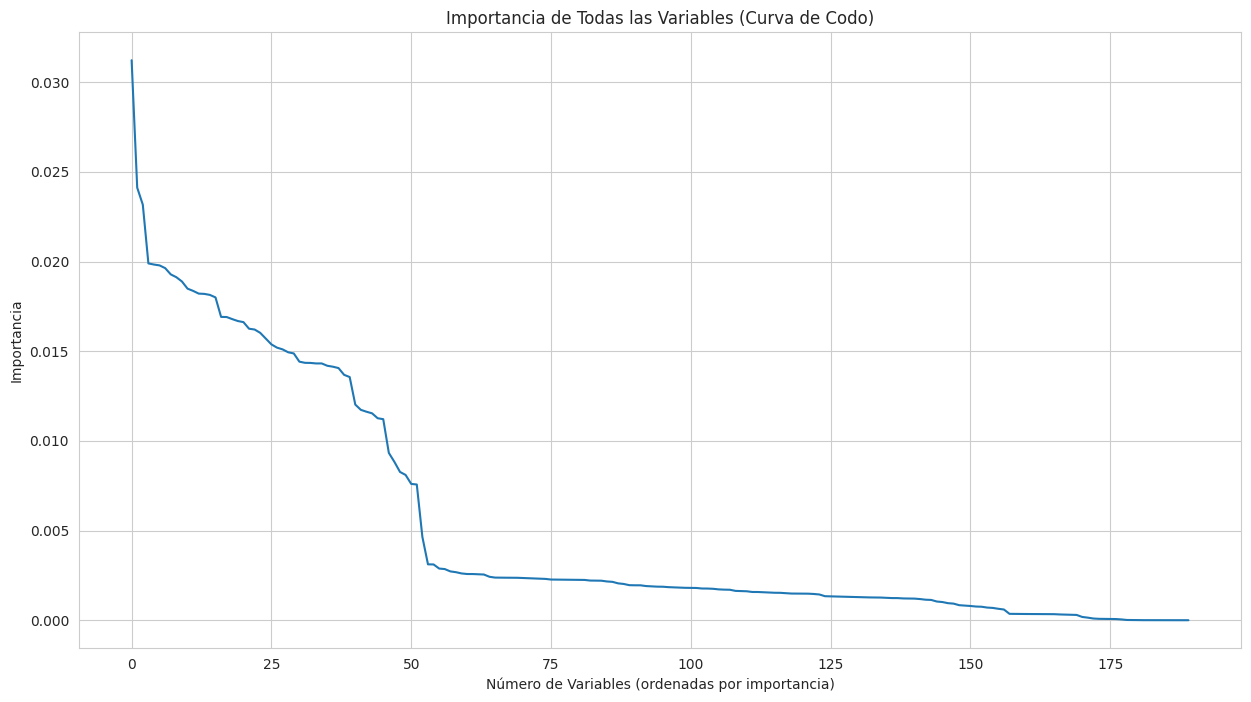

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(range(len(feature_importance)), feature_importance['importance'])
plt.title('Importancia de Todas las Variables (Curva de Codo)')
plt.xlabel('Número de Variables (ordenadas por importancia)')
plt.ylabel('Importancia')
plt.grid(True)
plt.show()

In [ ]:
k = 50

final_features = feature_importance['feature'].head(k).tolist()

print(final_features)

X_train_final = X_encoded[final_features]
y_train = y_train
df_final_train = pd.concat([X_train_final, y_train], axis=1)
df_final_train.head()

['eqpdays', 'change_mou', 'months', 'adjrev', 'totrev', 'mou_Mean', 'avgqty', 'change_rev', 'avgrev', 'avgmou', 'rev_Mean', 'totcalls', 'adjqty', 'avg3mou', 'totmou', 'adjmou', 'avg6mou', 'mou_peav_Mean', 'mou_cvce_Mean', 'mou_opkv_Mean', 'avg3qty', 'avg6qty', 'mouowylisv_Mean', 'totmrc_Mean', 'mou_rvce_Mean', 'peak_vce_Mean', 'avg6rev', 'opk_vce_Mean', 'unan_vce_Mean', 'avg3rev', 'comp_vce_Mean', 'recv_vce_Mean', 'owylis_vce_Mean', 'attempt_Mean', 'complete_Mean', 'plcd_vce_Mean', 'drop_blk_Mean', 'inonemin_Mean', 'drop_vce_Mean', 'mouiwylisv_Mean', 'ovrmou_Mean', 'ovrrev_Mean', 'hnd_price', 'iwylis_vce_Mean', 'blck_vce_Mean', 'vceovr_Mean', 'cc_mou_Mean', 'da_Mean', 'roam_Mean', 'ccrndmou_Mean']


,eqpdays,change_mou,months,adjrev,totrev,mou_Mean,avgqty,change_rev,avgrev,avgmou,rev_Mean,totcalls,adjqty,avg3mou,totmou,adjmou,avg6mou,mou_peav_Mean,mou_cvce_Mean,mou_opkv_Mean,avg3qty,avg6qty,mouowylisv_Mean,totmrc_Mean,mou_rvce_Mean,peak_vce_Mean,avg6rev,opk_vce_Mean,unan_vce_Mean,avg3rev,comp_vce_Mean,recv_vce_Mean,owylis_vce_Mean,attempt_Mean,complete_Mean,plcd_vce_Mean,drop_blk_Mean,inonemin_Mean,drop_vce_Mean,mouiwylisv_Mean,ovrmou_Mean,ovrrev_Mean,hnd_price,iwylis_vce_Mean,blck_vce_Mean,vceovr_Mean,cc_mou_Mean,da_Mean,roam_Mean,ccrndmou_Mean,churn
0,601.0,-704.00,20,2257.35,2312.52,784.00,409.95,-86.7125,118.81,840.00,137.4925,7810,7789,1019,15986.0,15960.0,941.0,462.530000,286.536667,97.650000,445,441.0,23.993333,50.0000,273.643333,204.000000,143.0,63.333333,19.666667,166,180.333333,91.333333,33.666667,233.000000,180.333333,233.000000,34.000000,30.333333,3.333333,0.000000,272.50,81.750,59.98999,0.000000,30.666667,81.750,0.000000,3.96,1.7825,0.0,1
1,156.0,264.75,19,1017.85,1107.83,1702.25,254.47,-9.0750,59.87,1344.29,59.0650,4333,4326,1614,22876.0,22853.0,1458.0,367.333333,846.830000,761.720000,285,277.0,191.696667,59.9900,282.223333,103.333333,57.0,122.333333,41.333333,62,179.666667,47.000000,79.333333,235.666667,179.666667,235.666667,15.666667,15.666667,9.000000,62.930000,30.25,9.075,199.98999,12.666667,6.666667,9.075,1.843333,0.00,0.0000,2.0,0
2,1009.0,-70.25,33,1139.68,1194.37,185.25,64.59,-11.5000,39.30,193.86,44.4700,1928,1873,209,5774.0,5622.0,200.0,104.316667,123.030000,24.690000,81,70.0,1.860000,30.0000,5.976667,52.666667,40.0,16.000000,13.333333,48,64.000000,7.333333,2.000000,78.333333,64.000000,78.333333,1.000000,5.333333,1.000000,0.000000,28.75,11.500,29.98999,0.000000,0.000000,11.500,0.000000,2.97,0.0000,0.0,0
3,334.0,-3.75,11,290.96,350.94,10.75,8.20,-0.2550,29.10,14.40,28.7450,85,82,12,150.0,144.0,13.0,0.000000,0.000000,0.000000,7,8.0,0.000000,39.9900,0.000000,0.000000,29.0,0.000000,0.000000,29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000,149.98999,0.000000,0.000000,0.000,0.000000,0.00,0.0000,0.0,0
4,223.0,84.50,7,581.85,667.73,1757.50,343.50,-30.2025,96.98,1494.83,109.1925,2074,2061,1729,9107.0,8969.0,1495.0,508.236667,1184.570000,895.386667,355,344.0,97.853333,82.6925,219.053333,222.000000,97.0,215.000000,159.333333,119,349.000000,175.666667,59.666667,528.333333,349.000000,528.333333,21.000000,127.000000,19.666667,67.196667,113.75,45.500,129.98999,14.000000,1.333333,45.500,40.876667,0.00,0.0000,65.0,1


In [ ]:
import sys
import os

# Obtenemos la ruta del directorio actual del notebook (que será '.../notebooks')
notebook_dir = os.getcwd()
# Subimos un nivel para llegar a la raíz del proyecto ('.../churn-estimation')
project_root = os.path.dirname(notebook_dir)

# Añadimos la raíz del proyecto a la lista de rutas donde Python busca módulos
if project_root not in sys.path:
    sys.path.append(project_root)

print(f"Raíz del proyecto añadida al path: {project_root}")

Raíz del proyecto añadida al path: /home/paloma/churn-estimation


## Comparación de resultados

In [ ]:
# Creamos un DataFrame a partir de la lista de resultados
# Excluimos la columna del objeto del modelo para que la tabla sea más limpia
results_df = pd.DataFrame([res for res in all_results])
results_df_cleaned = results_df.drop(columns=['model_object'])

# Ordenamos por la métrica que más nos interese (ej. AUC) para ver al campeón
results_df_cleaned.sort_values(by='AUC Test', ascending=False)

,model_name,AUC Test,F1-Score Churn
2,LightGBM,0.681248,0.636708
1,XGBoost,0.669039,0.617206
0,RandomForest,0.661473,0.605996



--- ENTRENANDO Y EVALUANDO MODELO: LightGBM ---
Entrenando LightGBM...
[LightGBM] [Info] Number of positive: 39578, number of negative: 40252
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12673
[LightGBM] [Info] Number of data points in the train set: 79830, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
¡Modelo entrenado!

--- AUC en Test: 0.6822 ---

--- Informe de Clasificación en Test ---
              precision    recall  f1-score   support

    No Churn       0.64      0.60      0.62     10071
       Churn       0.62      0.66      0.64      9897

    accuracy                           0.63     19968
   macro avg       0.63      0.63      0.63     19968
weighted 

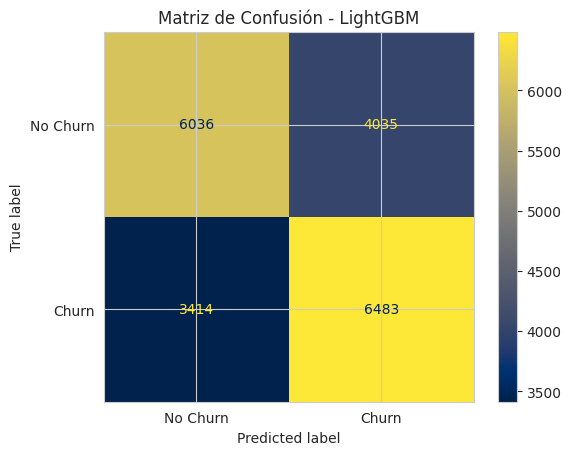

In [ ]:
X_train_final_60 = X_train[feature_importance['feature'].head(60).tolist()]
X_test_final_60 = X_test[feature_importance['feature'].head(60).tolist()]

lgbm_results_60 = train_and_evaluate_model('LightGBM', lgbm_params, X_train_final_60, y_train, X_test_final_60, y_test)


### Creación de ratios

In [ ]:
def create_ratio(df, numerator_col, denominator_col, new_col_name, handle_inf_with=0):
    """
    Crea una nueva feature dividiendo dos columnas existentes de forma segura.

    Args:
        df (pd.DataFrame): El DataFrame a modificar.
        numerator_col (str): El nombre de la columna del numerador.
        denominator_col (str): El nombre de la columna del denominador.
        new_col_name (str): El nombre de la nueva columna de ratio.
        handle_inf_with (float, optional): Valor con el que rellenar los infinitos/NaNs. 
                                            Defaults to 0.

    Returns:
        pd.DataFrame: El DataFrame con la nueva columna añadida.
    """
    # epsilon es un número diminuto para evitar la división por cero
    epsilon = 1e-6
    
    print(f"Creando feature de ratio: '{new_col_name}'...")
    df[new_col_name] = df[numerator_col] / (df[denominator_col] + epsilon)
    
    # Reemplazamos los posibles valores infinitos (si epsilon no fuera suficiente) por NaN
    df[new_col_name].replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Rellenamos cualquier NaN que haya quedado con el valor especificado
    df[new_col_name].fillna(handle_inf_with, inplace=True)
    
    return df

In [ ]:
def apply_feature_engineering(df):
    """
    Aplica toda la secuencia de creación de nuevas características a un DataFrame.
    Esta es nuestra "receta" maestra.
    """
    # Hacemos una copia para no modificar el DataFrame original por accidente
    df_out = df.copy()
    
    print(f"Aplicando feature engineering al DataFrame (tamaño inicial: {df_out.shape})...")
    
    # --- Herramienta 1: Ratios (usando nuestra función genérica) ---
    df_out = create_ratio(df_out, 'mou_Mean', 'months', 'mou_per_month')
    df_out = create_ratio(df_out, 'rev_Mean', 'mou_Mean', 'rev_per_minute')
    df_out = create_ratio(df_out, 'change_mou', 'mou_Mean', 'change_mou_relative')
    
    print(f"Feature engineering aplicado. Nuevo tamaño: {df_out.shape}")
    return df_out

In [ ]:
print("Procesando el set de entrenamiento...")
df_train_with_features = apply_feature_engineering(df_train)

print("\nProcesando el set de prueba...")
df_test_with_features = apply_feature_engineering(df_test_processed)

### Agrupación de variables numéricas

### Interacciones entre variables